# **4. Bài toán phân loại**

## **4.1. Mục tiêu**
* Lựa chọn thuật toán tối ưu
* Đánh giá thuật toán tối ưu
* Tìm xem đặc trưng nào ảnh hưởng mạnh nhất đến với biến mục tiêu `is_cancel`
* Dự đoán xem khả năng hủy phòng có thể xảy ra hay không và quyết định do yếu tố nào

## **4.2. Import thư viện & Load dữ liệu**

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
df = pd.read_csv('hotel_booking_classification.csv')
X_train = pd.read_csv('hotel_booking_classification_train.csv')
y_train = pd.read_csv('hotel_booking_classification_train_target.csv')
X_test = pd.read_csv('hotel_booking_classification_test.csv')
y_test = pd.read_csv('hotel_booking_classification_test_target.csv')

In [23]:
df.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((87229, 40), (69783, 39), (69783, 1), (17446, 39), (17446, 1))

In [24]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_stay', 'total_guests', 'is_family_trip', 'has_previous_cancel',
       'adr_per_guest', 'arrival_month_num', 'season', 'arrival_weekday',
       'lead_time_log', 'adr_log'],
      dtype='object')

In [25]:
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

print("Numeric:", num_cols) # Xác định cột số
print("Categorical:", cat_cols) # Xác định cột phân loại

Numeric: ['lead_time', 'arrival_date_year', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company', 'days_in_waiting_list', 'adr', 'required_car_parking_spaces', 'total_of_special_requests', 'total_stay', 'total_guests', 'is_family_trip', 'has_previous_cancel', 'adr_per_guest', 'arrival_month_num', 'arrival_weekday', 'lead_time_log', 'adr_log']
Categorical: ['hotel', 'arrival_date_month', 'meal', 'country', 'market_segment', 'distribution_channel', 'reserved_room_type', 'assigned_room_type', 'deposit_type', 'customer_type', 'season']


## **4.3. Lựa chọn mô hình**

In [26]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

# Pipeline cho cột phân loại: Imputer -> OrdinalEncoder
cat_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

# Pipeline cho cột số: Imputer -> passthrough
num_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median"))
])

rf_preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_pipeline, cat_cols),
        ("num", num_pipeline, num_cols),
    ]
)

rf_clf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=5,
    min_samples_split=10,
    max_features='sqrt',
    max_samples=0.8,
    class_weight='balanced',
    random_state=42
)

rf_pipeline = Pipeline(steps=[
    ("preprocess", rf_preprocessor),
    ("model", rf_clf)
])

rf_pipeline.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['hotel',
                                                   'arrival_date_month', 'meal',
                                                   'country', 'market_segment',
                                                   'distribution_channel',
                                                   'reserved_room_type',
                                                   'assigned_room_type',
                                                   'd...
                                                   'required_car_parking_spaces',
                                                   'total_of_special_requests',
                                                   'total_stay', 'total_guests',
                                                   'is_family_trip',
                                                   'has_previous_cancel',
                                                   'adr_per_guest',
                                                   'arrival_month_num',
                                                   'arrival_weekday',
                                                   'lead_time_log',
                                                   'adr_log'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        max_samples=0.8, min_samples_leaf=5,
                                        min_samples_split=10, n_estimators=300,
                                        random_state=42))])

In [27]:
# -----------------------------------
# 2. Xây dựng mô hình Decision Tree
# -----------------------------------
from sklearn.tree import DecisionTreeClassifier

dt_preprocessor = rf_preprocessor  # dùng chung

dt_clf = DecisionTreeClassifier(
    criterion="gini",       # hoặc "entropy"
    max_depth=8,            # 6–12 là khoảng hay dùng
    min_samples_split=20,   # tránh tách quá vụn
    min_samples_leaf=10,    # mỗi lá phải có >= 10 mẫu
    max_features="sqrt",    # chọn ngẫu nhiên subset feature
    class_weight="balanced",
    random_state=42
)

dt_pipeline = Pipeline(steps=[
    ("preprocess", dt_preprocessor),
    ("model", dt_clf)
])

dt_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['hotel',
                                                   'arrival_date_month', 'meal',
                                                   'country', 'market_segment',
                                                   'distribution_channel',
                                                   'reserved_room_type',
                                                   'assigned_room_type',
                                                   'd...
                                                   'required_car_parking_spaces',
                                                   'total_of_special_requests',
                                                   'total_stay', 'total_guests',
                                                   'is_family_trip',
                                                   'has_previous_cancel',
                                                   'adr_per_guest',
                                                   'arrival_month_num',
                                                   'arrival_weekday',
                                                   'lead_time_log',
                                                   'adr_log'])])),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=8,
                                        max_features='sqrt',
                                        min_samples_leaf=10,
                                        min_samples_split=20,
                                        random_state=42))])

In [28]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Pipeline cho cột số (numeric)
num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),   # hoặc "median"
    ("scaler", StandardScaler())
])

# Pipeline cho cột phân loại (categorical)
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

# Kết hợp
lin_preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_cols),
        ("cat", cat_transformer, cat_cols)
    ]
)


In [29]:
# -----------------------------------
# 3. Xây dựng mô hình Logistic Regression
# -----------------------------------
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(
    penalty="l2",
    C=1.0,                  # mức regularization trung bình
    solver="lbfgs",         # tốt cho dữ liệu vừa/lớn
    max_iter=1000,
    class_weight="balanced" # xử lý lệch lớp
)

lr_pipeline = Pipeline(steps=[
    ("preprocess", lin_preprocessor),
    ("model", lr_clf)
])

lr_pipeline.fit(X_train, y_train)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['lead_time',
                                                   'arrival_date_year',
                                                   'arrival_date_week_number',
                                                   'arrival_date_day_of_month',
                                                   'stays_in_weekend_nights',
                                                   'stays_in_week_nights',
                                                   'adults', 'children',
                                                   'babies',
                                                   'is_repeated_guest',
                                                   'previous_cancellatio...
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['hotel',
                                                   'arrival_date_month', 'meal',
                                                   'country', 'market_segment',
                                                   'distribution_channel',
                                                   'reserved_room_type',
                                                   'assigned_room_type',
                                                   'deposit_type',
                                                   'customer_type',
                                                   'season'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000))])

## **4.4. Đánh giá mô hình**

In [30]:
from sklearn.metrics import classification_report, roc_auc_score

In [33]:
# -----------------------------------
# 1. Xây dựng mô hình Random Forest
# -----------------------------------

y_pred_rf = rf_pipeline.predict(X_test)
y_proba_rf = rf_pipeline.predict_proba(X_test)[:, 1]

print("Random Forest AUC:", roc_auc_score(y_test, y_proba_rf))
print(classification_report(y_test, y_pred_rf))

Random Forest AUC: 0.8878061260723775
              precision    recall  f1-score   support

           0       0.94      0.72      0.82     12644
           1       0.55      0.88      0.68      4802

    accuracy                           0.77     17446
   macro avg       0.74      0.80      0.75     17446
weighted avg       0.83      0.77      0.78     17446



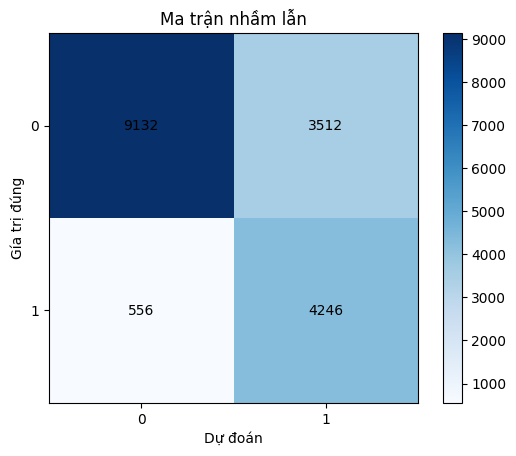

In [34]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_rf)
labels = np.unique(y_test)

plt.imshow(cm, cmap="Blues")
plt.title("Ma trận nhầm lẫn")
plt.xlabel("Dự đoán")
plt.ylabel("Gía trị đúng")

plt.xticks(np.arange(len(labels)), labels)
plt.yticks(np.arange(len(labels)), labels)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.colorbar()
plt.show()

AUC: 0.8878061260723775


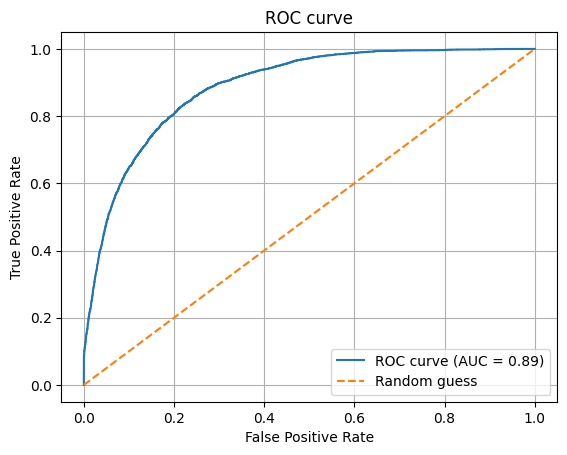

In [35]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_proba_rf)
auc = roc_auc_score(y_test, y_proba_rf)

print("AUC:", auc)

# 6. Vẽ đường ROC
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], '--', label='Random guess')  # đường chéo ngẫu nhiên
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [36]:
# -----------------------------------
# 2. Đánh giá mô hình Decision Tree
# -----------------------------------
y_pred_dt = dt_pipeline.predict(X_test)
y_proba_dt = dt_pipeline.predict_proba(X_test)[:, 1]

print("Decision Tree AUC:", roc_auc_score(y_test, y_proba_dt))
print(classification_report(y_test, y_pred_dt))

Decision Tree AUC: 0.8051903133791269
              precision    recall  f1-score   support

           0       0.94      0.58      0.72     12644
           1       0.45      0.90      0.60      4802

    accuracy                           0.67     17446
   macro avg       0.69      0.74      0.66     17446
weighted avg       0.80      0.67      0.68     17446



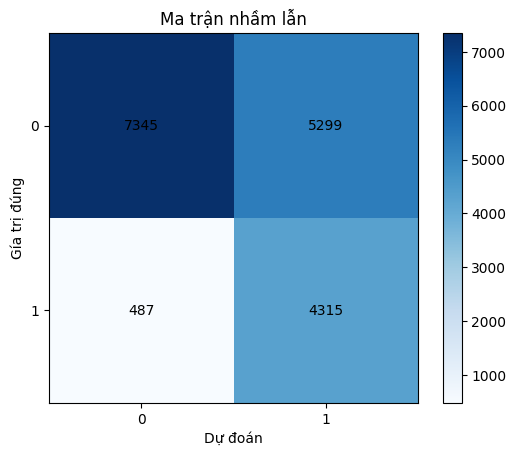

In [37]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_dt)
labels = np.unique(y_test)

plt.imshow(cm, cmap="Blues")
plt.title("Ma trận nhầm lẫn")
plt.xlabel("Dự đoán")
plt.ylabel("Gía trị đúng")

plt.xticks(np.arange(len(labels)), labels)
plt.yticks(np.arange(len(labels)), labels)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.colorbar()
plt.show()

AUC: 0.8051903133791269


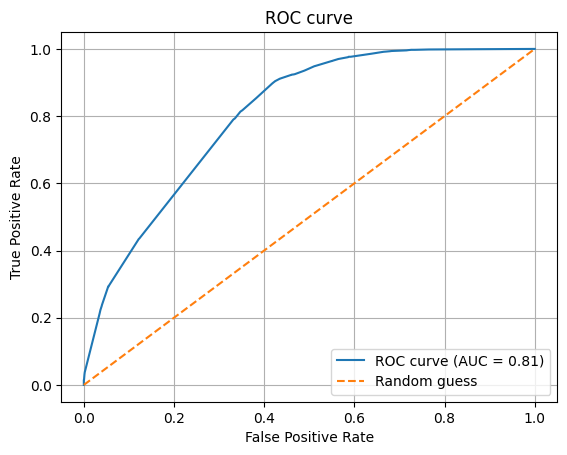

In [38]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_proba_dt)
auc = roc_auc_score(y_test, y_proba_dt)

print("AUC:", auc)

# 6. Vẽ đường ROC
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], '--', label='Random guess')  # đường chéo ngẫu nhiên
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

In [39]:
# -----------------------------------
# 3. Đánh giá mô hình Logistic Regression
# -----------------------------------
y_pred_lr = lr_pipeline.predict(X_test)
y_proba_lr = lr_pipeline.predict_proba(X_test)[:, 1]

print("Logistic Regression AUC:", roc_auc_score(y_test, y_proba_lr))
print(classification_report(y_test, y_pred_lr))

Logistic Regression AUC: 0.8649883949150682
              precision    recall  f1-score   support

           0       0.92      0.75      0.83     12644
           1       0.56      0.82      0.67      4802

    accuracy                           0.77     17446
   macro avg       0.74      0.79      0.75     17446
weighted avg       0.82      0.77      0.78     17446



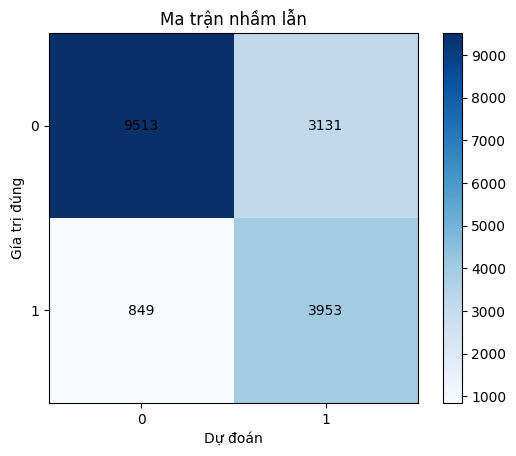

In [40]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_lr)
labels = np.unique(y_test)

plt.imshow(cm, cmap="Blues")
plt.title("Ma trận nhầm lẫn")
plt.xlabel("Dự đoán")
plt.ylabel("Gía trị đúng")

plt.xticks(np.arange(len(labels)), labels)
plt.yticks(np.arange(len(labels)), labels)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")

plt.colorbar()
plt.show()

AUC: 0.8649883949150682


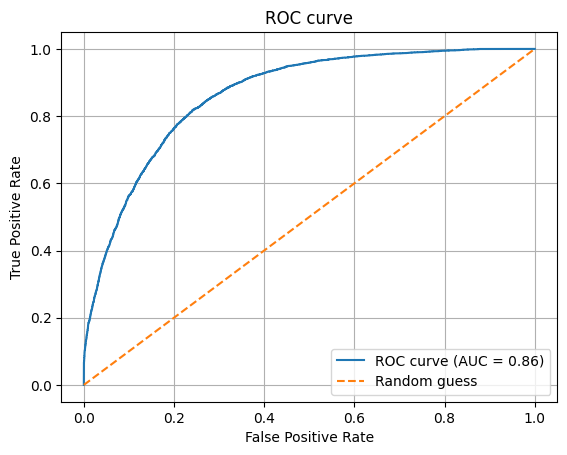

In [41]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_proba_lr)
auc = roc_auc_score(y_test, y_proba_lr)

print("AUC:", auc)

# 6. Vẽ đường ROC
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], '--', label='Random guess')  # đường chéo ngẫu nhiên
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

## **4.5. Kết luận và tìm biến quan trọng**

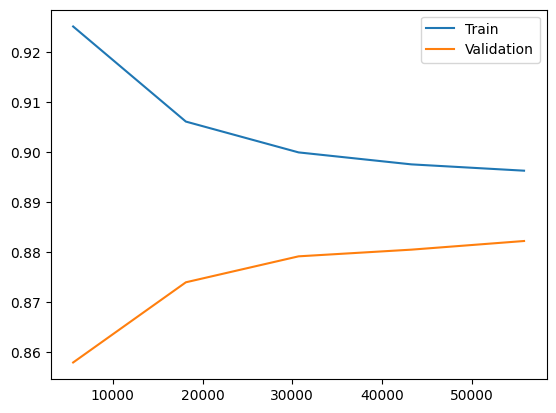

In [42]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

train_sizes, train_scores, val_scores = learning_curve(
    rf_pipeline,
    X_train, y_train,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

plt.plot(train_sizes, train_scores.mean(axis=1), label="Train")
plt.plot(train_sizes, val_scores.mean(axis=1), label="Validation")
plt.legend()
plt.show()


Tối ưu nhất chính là mô hình Random Forest đồng thời biểu đồ trên cũng cho ta thấy rằng mô hình không bị ovèrfitting tiếp đến ta có thể thực hiện tuning lựa chọn thanm số tối ưu cho mô hình và lựa chọn xem đặc trưng nào là quan trọng nhất trong quá trình dự đoán

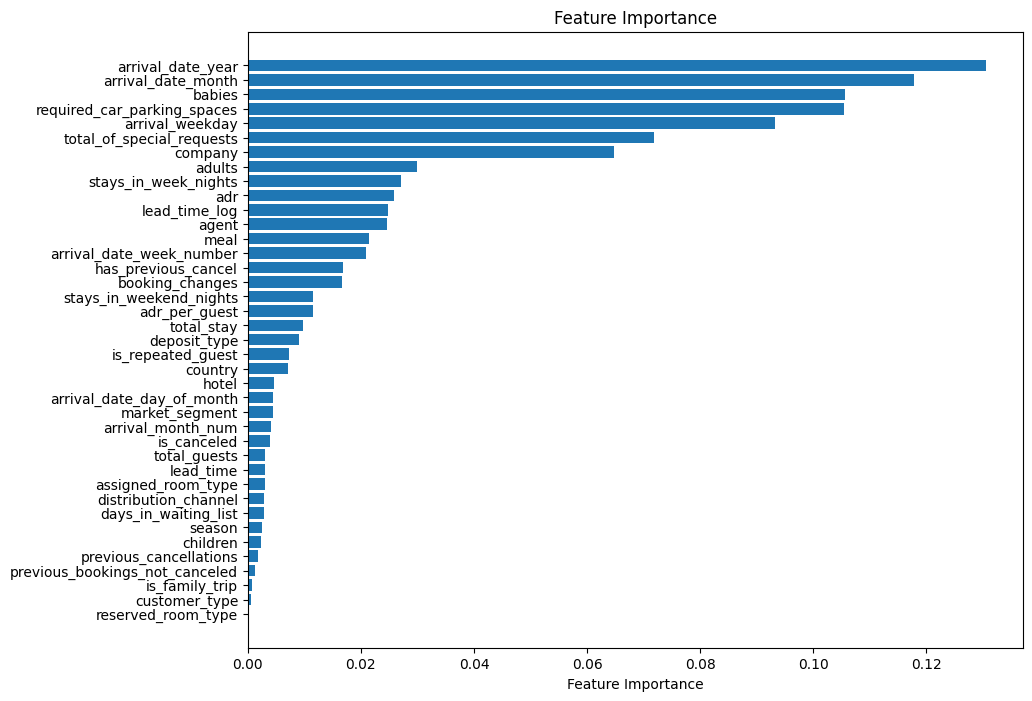

In [44]:
importances = rf_clf.feature_importances_
feature_names = df.columns

# Sắp xếp
indices = np.argsort(importances)

# Vẽ biểu đồ
plt.figure(figsize=(10, 8))
plt.barh(feature_names[indices], importances[indices])
plt.xlabel("Feature Importance")
plt.title("Feature Importance")
plt.show()